# Deep Q-Learning - Banana Navigation Training

### 1. Import the Necessary Packages / Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/) and [Torch](https://pytorch.org/docs/stable/torch.html) are installed.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

from dqn_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [1]:
# env = UnityEnvironment(file_name="C:/Users/doegstra/LRZ Sync+Share/Promotion und Weiterbildung/Udacity/Deep Reinforcement Learning/repository/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana.exe")
env = UnityEnvironment(file_name="path/to/Banana_Windows_x86/Banana.exe")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train the agent to solve the environment
Run the code cell below to train the agent from scratch. 
The `dqn()` method uses the Python API to control the agent and receive feedback from the environment.
The environment is considered solved once the agents reaches an average score of 13 over the last 100 steps. 
After successfully solving the environment, the trained model is stored to disk as `checkpoint.pth`.

To watch a trained and untrained agent in comparison, please visit `NavigationWatchAgents.ipynb`.

In [2]:
def dqn(n_episodes=2_000, max_t=2_000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
       average_score_to_reach=13, score_window_length=100):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        average_score_to_reach (float): to solve the environment the agent must get this average rewards
        score_window_length (int): last n iterations which are considered for calculating average_score_to_reach
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=score_window_length)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = np.int16(agent.act(state, eps)).item() # select an action # casts to <class 'int'> 
            env_info = env.step(action)[brain_name]         # send the action to the environment
            next_state = env_info.vector_observations[0]    # get the next state
            reward = env_info.rewards[0]                    # get the reward
            done = env_info.local_done[0]                   # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                 # update the score
            state = next_state                              # roll over the state to next time step
            if done:                                        # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if len(scores_window) >= score_window_length:
            if np.mean(scores_window) >= average_score_to_reach: 
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-score_window_length, np.mean(scores_window)))
                checkpoint = {'input_size': state_size,
                              'output_size': action_size,
                              'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
                              'state_dict': agent.qnetwork_local.state_dict()}
                torch.save(checkpoint, 'checkpoint.pth')
                break    
        
    return scores

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = dqn()

Episode 100	Average Score: 0.32
Episode 200	Average Score: 1.09
Episode 300	Average Score: 2.17
Episode 400	Average Score: 4.57
Episode 500	Average Score: 4.96
Episode 600	Average Score: 5.37
Episode 700	Average Score: 7.48
Episode 800	Average Score: 9.17
Episode 900	Average Score: 10.89
Episode 1000	Average Score: 11.37
Episode 1075	Average Score: 13.03
Environment solved in 975 episodes!	Average Score: 13.03


#### Plot the scores 

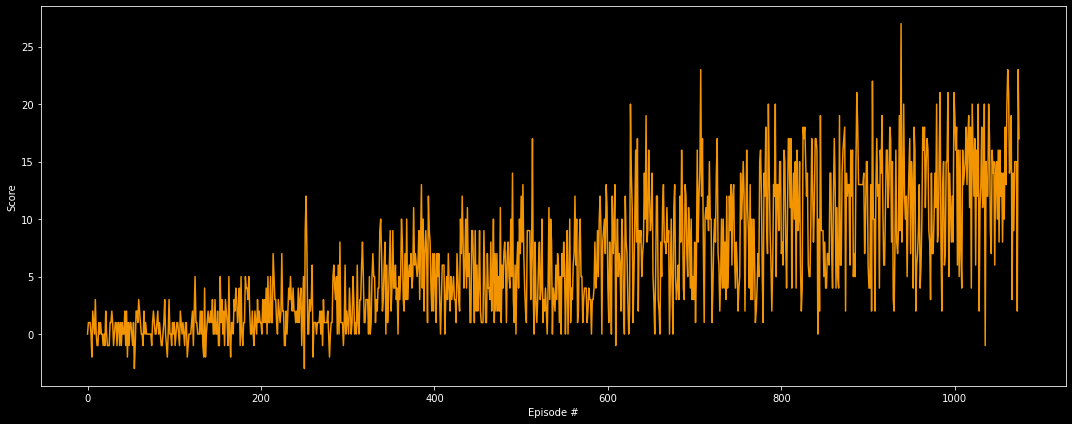

In [88]:
fig1, ax = plt.subplots(figsize=(15,6))
ax.plot(np.arange(len(scores)), scores, color="#F39500") 
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.tight_layout()
# save figure as .png
fig1.savefig("rewards_over_time_dark.png", dpi=150)
plt.show()

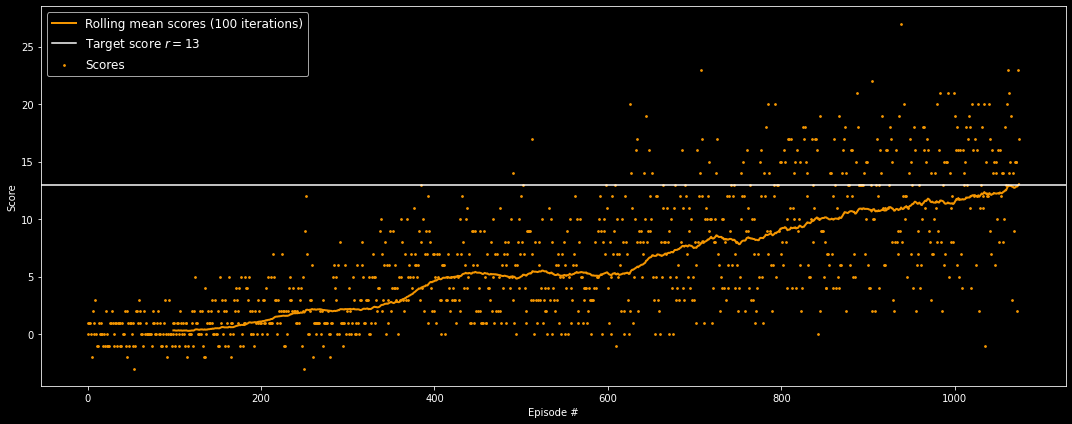

In [93]:
fig2, ax = plt.subplots(figsize=(15,6))
ax.scatter(np.arange(len(scores)), scores, color="#F39500", s=3, marker='o', label="Scores")
plt.plot(np.arange(len(scores))[99:], np.convolve(scores, np.ones(100)/100, mode='valid'), 
         color="#F39500", label="Rolling mean scores (100 iterations)", lw=2)
ax.axhline(13, color="#ffffff", label="Target score $r=13$")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(prop={'size': 12})
plt.tight_layout()
# export fig 
fig2.savefig("rewards_over_time_rolling_dark_v2.png", dpi=150)
plt.show()

#### When finished, you can close the environment.

In [9]:
env.close()